In [1]:
%%capture
import numpy as np
import pandas as pd
!pip install openpyxl
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [28]:
bandwidth = 2
for_r = 35
#band=2,r=40, 5 correctly classified
#bandwith=2,r=35 5 correctly classified

In [3]:
actual_path = os.getcwd()
os.chdir('/home/onyxia/work/material_science/Spetral_clustering')
%run rbf.ipynb
os.chdir(actual_path)

In [4]:
max_calculated = pd.read_csv('max_calculated.csv')
max_elemental = pd.read_csv('max_elemental.csv')
list_mxene = pd.read_excel('synthesized-MXenes-MAX.xlsx',sheet_name=0)
list_failed = pd.read_excel('synthesized-MXenes-MAX.xlsx', sheet_name=2)
n_samples = max_elemental.shape[0]
synth_list = pd.unique(list_mxene['MXene'])[:-1]
to_drop = list(range(167,173))
mx_ene_df = list_mxene.drop(labels = to_drop, axis='index')
mx_ene_df = mx_ene_df.drop(['Unnamed: 9','Unnamed: 12','Notes','status','Reference method'],axis=1)
max_elemental['class'] = np.zeros(max_elemental.shape[0])
parents = mx_ene_df['Parent material'].unique()
banned_words = ['+','Mxene','topochemical','reaction', 'or',
               'synthesis','MXene','direct']
complete_parents = []
for i in range(len(parents)):
    inter = parents[i].split()
    for word in range(len(inter)):
        if inter[word] not in banned_words:
            complete_parents.append(inter[word])


for i in range(max_elemental.shape[0]):
    if max_elemental.loc[i,'compound_formula'] in complete_parents:
        max_elemental.loc[i,'class'] = 1

max_elemental = max_elemental.set_index('compound_formula',drop=True)
max_elemental = max_elemental.drop(['M_element', 'A_element', 'X_element'],axis=1)
max_calculated = max_calculated.set_index('prettyformula',drop=True)
whole_data = max_elemental.copy()
x_group = pd.get_dummies(whole_data['X_X_group'],prefix='x_g',dtype=float)
a_group = pd.get_dummies(whole_data['A_A_group'],prefix='a_g',dtype=float)
m_group = pd.get_dummies(whole_data['M_M_group'],prefix='m_g',dtype=float)
whole_data = whole_data.drop(['X_X_group','A_A_group','M_M_group'],axis=1)
whole_data = pd.concat([whole_data,x_group,a_group,m_group],axis=1)

test_tree = DecisionTreeClassifier().fit(X=whole_data.drop(['class'],axis=1),
                                                              y=whole_data['class'])

imp_feat = test_tree.feature_importances_
names_feat = test_tree.feature_names_in_

imp_feat = imp_feat.reshape(-1,1)
names_feat = names_feat.reshape(-1,1)
test_df = pd.DataFrame(np.hstack((names_feat,imp_feat)))
test_df.columns = ['names_feat','imp_feat']
test_df = test_df.set_index('names_feat',drop=True)
test_df = test_df[test_df['imp_feat'] > 0]

diff_z = list(test_df.index)


number_of_atoms = np.zeros(n_samples)
compteur = 0
for element in whole_data.index:
    inter = []
    for cara in element:
        if cara in list(str(1234567890)):
            inter.append(cara)
    if len(inter) == 1:
        number_of_atoms[compteur] = int(inter[0]) + 2
    elif len(inter) == 2:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + 1
    elif len(inter) == 3:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + int(inter[2])
    compteur += 1

columns_name = whole_data.drop(['class'],axis=1).columns.copy()
normalized = whole_data.drop(['class'],axis=1).to_numpy()/number_of_atoms.reshape(-1,1)

data_norm = pd.DataFrame(normalized)
data_norm.columns = columns_name
data_norm['compound_name'] = whole_data.index
data_norm = data_norm.set_index('compound_name',drop=True)

data_norm = data_norm.filter(items=list(diff_z),axis=1)
data_norm['class'] = whole_data['class'].copy()

retained_features = list(test_df.index)

for feat in diff_z:
    if len(feat) > 5:
        retained_features.remove(feat)

list_dummies = []

for i in retained_features:
    if 'M_' in i:
        list_dummies.append(i)
    elif 'A_' in i:
        list_dummies.append(i)
    elif 'X_' in i:
        list_dummies.append(i)

for col in list_dummies:
    for row in data_norm.index:
        if data_norm.loc[row,col] != 0:
            data_norm.loc[row,col] = 1

In [5]:
list_inertia = np.zeros(10)
for i in range(1,11):
    det_n_clusters = KMeans(n_clusters=i,random_state=1786167).fit(X=data_norm.drop(['class'],axis=1).to_numpy())
    list_inertia[i-1] = det_n_clusters.inertia_

In [6]:
#let's stick with 4 clusters, seems well enough
#turns out it's not because the positive are too spread

In [7]:
data_norm['label'] = np.zeros(n_samples)
for i in data_norm.index:
    if data_norm.loc[i,'class'] == 1:
        data_norm.loc[i,'label'] = 1
    else:
        data_norm.loc[i,'label'] = -1

positive_samples = data_norm[data_norm['label'] == 1]
unlabelled_samples = data_norm[data_norm['label'] == -1]

n_cluster = 4
clusterized_data = KMeans(n_clusters=n_cluster, random_state=1871687).fit(data_norm.to_numpy()[:,:-2])
data_norm['cluster'] = clusterized_data.labels_

list_of_ratio = np.zeros(n_cluster)
for i in range(n_cluster):
    list_of_ratio[i] = data_norm[data_norm['cluster'] == i]['class'].sum()/data_norm[data_norm['cluster'] == i].shape[0]
#same code as before but here we use the class because it is 0 or 1
positive_cluster = np.argmax(list_of_ratio)
    
#we cannot exactly compute the ratios because the classes are so unbalanced that in any cases the number of positive
#instances will be very small compared to the ones of unlabelled instances

list_of_dist = np.zeros(n_cluster)
for i in range(n_cluster):
    list_of_dist[i] = np.linalg.norm(clusterized_data.cluster_centers_[positive_cluster,:] - clusterized_data.cluster_centers_[i,:])

negative_cluster = np.argmax(list_of_dist)

In [8]:
df_unlab_pop = data_norm[data_norm['label'] == -1]
list_of_pop = pd.DataFrame(df_unlab_pop.groupby('cluster')['label'].count())
list_of_pop.columns = ['pop']
list_of_pop['dist'] = list_of_dist #distance to the positive cluster
list_of_pop = list_of_pop.sort_values('dist',ascending=False)
list_of_pop['cumsum'] = np.cumsum(list_of_pop['pop'])

In [9]:
reliable_positives = data_norm[data_norm['label'] == 1]
n_positives = reliable_positives.shape[0]
last_step = np.where(np.array(list_of_pop['cumsum'])>n_positives*for_r)[0][0]
index_ordered_distance = list(list_of_pop.index)
if last_step == 0:
    reliable_negatives = data_norm[data_norm['cluster'] == negative_cluster]
    reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
else:
    compteur=0
    reliable_negatives = data_norm[data_norm['cluster'] == negative_cluster]
    reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
    while compteur<last_step:
        interm_negatives = data_norm[data_norm['cluster'] == index_ordered_distance[compteur+1]]
        interm_negatives = interm_negatives[interm_negatives['label'] == -1]
        reliable_negatives = pd.concat([reliable_negatives,interm_negatives])
        compteur += 1
    del interm_negatives, compteur

In [10]:
reliable_negatives = reliable_negatives.head(n=n_positives*for_r)

In [11]:
#Step of initialization of labels
train_clf_data = pd.concat([reliable_positives,reliable_negatives])
index_of_labels = list(train_clf_data.index)
unlabelled_data = data_norm.drop(labels=index_of_labels,axis=0)
index_of_unlabelled = list(unlabelled_data.index)
first_step_clf = SVC().fit(X=train_clf_data.drop(['class','label','cluster'],axis=1).to_numpy(),
                          y=train_clf_data['label'].to_numpy())
unlabelled_data['relab'] = first_step_clf.predict(unlabelled_data.drop(['class','label','cluster'],axis=1).to_numpy())

In [12]:
gamma = 1
good_ratio = 1/for_r
max_iter = 10
compteur = 0
train_clf_data['relab'] = train_clf_data['label'].copy()
updated_data = pd.concat([train_clf_data,unlabelled_data])
up_data_np = updated_data.to_numpy()[:,:-4].copy()
positive_index_list = list(data_norm[data_norm['class'] == 1].index)

In [13]:
right_side = np.vstack((np.zeros(1).reshape(1,1),np.ones(n_samples).reshape(n_samples,1))) #its for the 
#computation of the matrix to det the coeffs so put it here to avoid doing it each time
while compteur<max_iter:
    compteur += 1
    labels = updated_data['relab'].to_numpy().reshape(1,-1)
    first_row = np.hstack((np.array(0).reshape(1,1),(-1)*labels))
    
    #computation of omega and the coefficients
    omega = np.zeros((n_samples,n_samples))
    for i in range(n_samples):
        for k in range(i,n_samples):
            omega[i,k] = rbf(x=up_data_np[i,:],y=up_data_np[k,:],l_squared=bandwidth)*labels[0,i]*labels[0,k]
            omega[k,i] = omega[i,k]
        omega[i,i] = 1

    bot_right = omega + gamma*np.eye(n_samples)
    bot = np.hstack((updated_data['relab'].to_numpy().reshape(n_samples,1), bot_right))
    whole_mat = np.vstack((first_row, bot))
    
    del bot_right, bot, first_row

    coeffs = np.linalg.solve(a=whole_mat,b=right_side)


    alpha = coeffs[1:]

    #once we have the coefficients, we can compute the labels of the unlabelled instances

    updated_data['to_det_b'] = np.zeros(n_samples)
    count_for_loop = 0
    for i in updated_data.index:
        updated_data.loc[i,'to_det_b'] = np.sum(alpha*labels.reshape(-1,1)*rbf(x=up_data_np,
                                                                               y=up_data_np[count_for_loop,:],
                                                                               l_squared=bandwidth).reshape(-1,1))
        count_for_loop += 1
    to_det_b_arr = np.array(updated_data['to_det_b']).copy()
    b = np.sort(to_det_b_arr)[int((1-good_ratio)*n_samples)]
    
    updated_data['check_array'] = np.zeros(n_samples)
    count_diff = 0
    
    for i in updated_data.index:
        if i in positive_index_list:
            updated_data.loc[i,'check_array'] = 1
        else:
            updated_data.loc[i,'check_array'] = np.sign(updated_data.loc[i,'to_det_b']-b)
            if updated_data.loc[i,'check_array'] != updated_data.loc[i,'relab']:
                count_diff += 1
    
    if count_diff == 0:
        break
    else:
        updated_data['relab'] = updated_data['check_array'].copy()

In [14]:
test_results = np.zeros(positive_samples.shape[0])
test_set = positive_samples.to_numpy()[:,:-2]

In [15]:
for i in range(positive_samples.shape[0]):
    test_results[i] = np.sign(np.sum(alpha*labels.reshape(-1,1)*rbf(x=up_data_np,
                                                                    y=test_set[i,:],
                                                                    l_squared=bandwidth).reshape(-1,1))-b)

In [16]:
true_positives = 0
for i in range(positive_samples.shape[0]):
    if test_results[i] == 1:
        true_positives += 1

In [17]:
recall = true_positives/positive_samples.shape[0]

In [18]:
#'V4AlC3' 'Nb4AlC3' are missclassified
#'Ta4AlC3' is the 'frontier', it's the one that defines 'r'

In [19]:
number_of_predicted_positives = 0
for i in updated_data.drop(labels=list(positive_samples.index),axis=0).index:
    if updated_data.loc[i,'check_array'] == 1:
        number_of_predicted_positives += 1

In [20]:
weird_metric = (recall**2)/(number_of_predicted_positives/updated_data.drop(labels=list(positive_samples.index),axis=0).shape[0])

In [21]:
ordered_pred_df = updated_data[updated_data['check_array'] == 1].sort_values(by='to_det_b',ascending=False)

In [22]:
ordered_pred_df[ordered_pred_df['class'] == 1]

,M_M_atomic_number,M_M_atomic_mass,M_M_average_cationic_radius,M_M_electronegativity,A_A_atomic_mass,A_A_density,A_A_average_cationic_radius,A_A_electron_affinity,A_A_second_ionization_energy,X_X_molar_volume,X_X_density,X_X_first_ionization_energy,m_g_5,class,label,cluster,relab,to_det_b,check_array
compound_name,,,,,,,,,,,,,,,,,,,
Ti3SnC2,3.666667,7.977833,0.141944,0.256667,19.785000,1.978500,0.138333,0.185345,2.438845,0.883333,0.377695,1.876715,0.000,1.0,1.0,3,1.0,1.884357,1.0
V2AlC,5.750000,12.735375,0.194375,0.407500,6.745385,0.674538,0.168750,0.108209,4.707137,1.325000,0.566542,2.815072,0.250,1.0,1.0,1,1.0,1.792721,1.0
Ti2AlN,5.500000,11.966750,0.212917,0.385000,6.745385,0.674538,0.168750,0.108209,4.707137,2.500000,0.350168,3.633532,0.000,1.0,1.0,1,1.0,1.520830,1.0
Ti2AlC,5.500000,11.966750,0.212917,0.385000,6.745385,0.674538,0.168750,0.108209,4.707137,1.325000,0.566542,2.815072,0.000,1.0,1.0,1,1.0,1.518639,1.0
Ti2SC,5.500000,11.966750,0.212917,0.385000,8.016250,0.801625,0.117500,0.519276,5.834470,1.325000,0.566542,2.815072,0.000,1.0,1.0,1,1.0,1.405569,1.0
Ta2AlC,18.250000,45.236970,0.205000,0.375000,6.745385,0.674538,0.168750,0.108209,4.707137,1.325000,0.566542,2.815072,0.250,1.0,1.0,0,1.0,0.338008,1.0
Ti2ZnC,5.500000,11.966750,0.212917,0.385000,16.352250,1.635225,0.220000,-0.155000,4.491098,1.325000,0.566542,2.815072,0.000,1.0,1.0,1,1.0,0.322940,1.0
Nb2AlC,10.250000,23.226595,0.205000,0.400000,6.745385,0.674538,0.168750,0.108209,4.707137,1.325000,0.566542,2.815072,0.250,1.0,1.0,1,1.0,0.316815,1.0
Ti3AlC2,3.666667,7.977833,0.141944,0.256667,4.496923,0.449692,0.112500,0.072139,3.138092,0.883333,0.377695,1.876715,0.000,1.0,1.0,1,1.0,0.271221,1.0


In [23]:
ordered_pred_df.to_csv('it_ls_svm_all_features.csv')

In [24]:
list_of_pos = list(positive_samples.index)
df_to_plot = updated_data.copy()
df_to_plot = df_to_plot.merge(max_calculated,how='left',left_index=True,
                              right_index=True)
df_to_plot = df_to_plot.filter(items=list(ordered_pred_df.index),axis=0)
df_to_plot['final_relab'] = np.sign(df_to_plot['to_det_b'].to_numpy() - b)
pred_pos = df_to_plot[df_to_plot['final_relab']==1]
true_pos_to_plot = pred_pos[pred_pos['class']==1]

df_no_pos = max_calculated.drop(labels=list(pred_pos.index),axis=0)
df_false_negatives = df_no_pos.merge(whole_data,how='left',left_index=True,
                                     right_index=True)
df_false_negatives = df_false_negatives[df_false_negatives['class'] == 1]



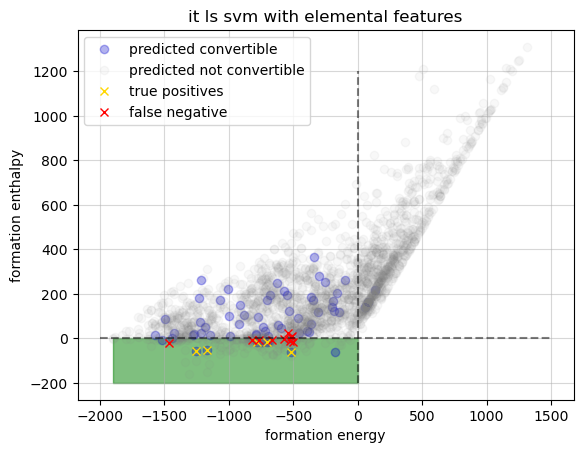

In [25]:
fig, ax = plt.subplots()

ax.plot(pred_pos['dEf'].to_numpy(),pred_pos['dH'].to_numpy(),'o', color='mediumblue', alpha=0.3,
         label='predicted convertible')
ax.plot(df_no_pos['dEf'].to_numpy(),df_no_pos['dH'].to_numpy(),'o',color='gray',alpha=0.05,
         label='predicted not convertible')
ax.plot(true_pos_to_plot['dEf'],true_pos_to_plot['dH'], 'x', color='gold',
        label='true positives')
ax.plot(df_false_negatives['dEf'],df_false_negatives['dH'], 'x', color='red',
        label='false negative')
ax.plot(np.linspace(-2000,1500,2,endpoint=True),np.zeros(2),'--k',alpha=0.5)
ax.plot(np.zeros(2),np.linspace(-200,1200,2,endpoint=True),'--k',alpha=0.5)
ax.fill_between(np.linspace(np.min(df_no_pos['dEf'].to_numpy()),0,2,endpoint=True),y1=-200,y2=0,color='green',alpha=0.5)
ax.grid(alpha=0.5)
ax.set_xlabel(xlabel='formation energy')
ax.set_ylabel(ylabel='formation enthalpy')
ax.set_title('it ls svm with elemental features')
plt.legend()
#plt.savefig('it_ls_svm_pred_elem_l_200_r_50.png')

In [26]:
true_pos_to_plot

,M_M_atomic_number,M_M_atomic_mass,M_M_average_cationic_radius,M_M_electronegativity,A_A_atomic_mass,A_A_density,A_A_average_cationic_radius,A_A_electron_affinity,A_A_second_ionization_energy,X_X_molar_volume,...,density,dEf,E_pa,dH,M,A,X,PU_label,year,final_relab
Ti3SnC2,3.666667,7.977833,0.141944,0.256667,19.785000,1.978500,0.138333,0.185345,2.438845,0.883333,...,5.897979,-782.892112,-8.471391,-15.472048,Ti,Sn,C,1.0,2007.0,1.0
V2AlC,5.750000,12.735375,0.194375,0.407500,6.745385,0.674538,0.168750,0.108209,4.707137,1.325000,...,4.850554,-515.645412,-8.299910,-62.501989,V,Al,C,1.0,1963.0,1.0
Ti2AlN,5.500000,11.966750,0.212917,0.385000,6.745385,0.674538,0.168750,0.108209,4.707137,2.500000,...,4.280719,-1171.435561,-8.139479,-53.570869,Ti,Al,N,1.0,1963.0,1.0
Ti2AlC,5.500000,11.966750,0.212917,0.385000,6.745385,0.674538,0.168750,0.108209,4.707137,1.325000,...,3.996838,-701.468727,-7.892082,-17.733162,Ti,Al,C,1.0,1963.0,1.0
Ti2SC,5.500000,11.966750,0.212917,0.385000,8.016250,0.801625,0.117500,0.519276,5.834470,1.325000,...,4.634328,-1251.700268,-8.540032,-56.625295,Ti,S,C,1.0,1960.0,1.0


In [27]:
print(compteur)

9
